In [1]:
import pandas as pd
import numpy as np
import re
import time

import bs4
import json

import glob
import tqdm

In [2]:
df = pd.read_csv("raw_data_with_labels.csv", index_col=0)
df = df[df['y'].notnull()]
df.shape

(501, 16)

In [3]:
df = df[df['watch-time-text'].notnull()]
df = df[df['watch-time-text'].str.contains('horas')==False]
df.shape

(473, 16)

In [4]:
df.head()

,watch-title,y,watch-view-count,watch-time-text,content_watch-info-tag-list,watch7-headline,watch7-user-header,watch8-sentiment-actions,og:image,og:image:width,og:image:height,og:description,og:video:width,og:video:height,og:video:tag,channel_link_0
0,Python For Data Science Full Course - 9 Hours ...,0.0,33.445 visualizações,Publicado em 15 de mar. de 2020,Educação,#edureka #PythonEdureka #pythonfordatasciencef...,edureka!\nCarregando...\nCancelar inscrição de...,33.445 visualizações\n1.003\nGostou deste víde...,https://i.ytimg.com/vi/-6RqxhNO2yY/maxresdefau...,1280,720,🔥Edureka Python Certification Training: https:...,1280.0,720.0,edureka,/channel/UCkw4JCwteGrDHIsyIIKo4tQ
1,Michael I. Jordan: Machine Learning: Dynamical...,1.0,4.640 visualizações,Publicado em 2 de mai. de 2019,Licença de atribuição Creative Commons (reutil...,#purdue #michaelijordan #engineering\nMichael ...,Purdue Engineering\nCarregando...\nCancelar in...,4.640 visualizações\n98\nGostou deste vídeo?\n...,https://i.ytimg.com/vi/-8yYFdV5SOc/maxresdefau...,1280,720,2019 Purdue Engineering Distinguished Lecture ...,1280.0,720.0,electrical engineer,/channel/UC8FZ6dzFVkCACLH9YoMNFog
2,Kaggle Live-Coding: RNNs for Sarcasm Detection...,1.0,1.570 visualizações,Transmitido ao vivo em 30 de nov. de 2018,Ciência e tecnologia,Kaggle Live-Coding: RNNs for Sarcasm Detection...,Kaggle\nCarregando...\nCancelar inscrição de K...,1.570 visualizações\n34\nGostou deste vídeo?\n...,https://i.ytimg.com/vi/-9U84J178OQ/maxresdefau...,1280,720,Join Kaggle data scientist Rachael live as she...,1280.0,720.0,CS,/channel/UCSNeZleDn9c74yQc-EKnVTA
3,Can You Become a Data Scientist?,0.0,699.800 visualizações,Publicado em 14 de ago. de 2018,Educação,#data #science #datascientist\nCan You Become ...,365 Data Science\nCarregando...\nCancelar insc...,699.800 visualizações\n10.749\nGostou deste ví...,https://i.ytimg.com/vi/-AkBfBWr_Gw/maxresdefau...,1280,720,👉 Download Our Free Data Science Career Guide:...,1280.0,720.0,data scientist,/channel/UCEBpSZhI1X8WaP-kY_2LLcg
4,Binary Image Classification with CNN (Deep Lea...,1.0,300 visualizações,Publicado em 23 de mar. de 2020,Ciência e tecnologia,#download #Kaggle #Google\nBinary Image Classi...,TheClassofAI\nCarregando...\nCancelar inscriçã...,300 visualizações\n9\nGostou deste vídeo?\nFaç...,https://i.ytimg.com/vi/-DDrE6T0ct4/hqdefault.jpg,480,360,"In this tutorial, we have covered how to train...",1280.0,720.0,ImageClassification,/channel/UCYlOdJBJQN4c7k25uzwSwJA


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


In [6]:
df_limpo = pd.DataFrame(index=df.index)

In [7]:
df_limpo.head()

""
0
1
2
3
4


## 1. Data cleaner

In [8]:
clean_date = df['watch-time-text'].str.extract(r"(\d+) de ([a-z]+)\. de (\d+)")
clean_date[0] = clean_date[0].map(lambda x: "0"+x[0] if len(x) == 1 else x)
#clean_date[1] = clean_date[1].map(lambda x: x[0].upper()+x[1:])

mapa_meses = {"jan": "Jan",
              "fev": "Feb",
              "mar": "Mar", 
              "abr": "Apr", 
              "mai": "May", 
              "jun": "Jun",
              "jul": "Jul",
              "ago": "Aug", 
              "set": "Sep", 
              "out": "Oct", 
              "nov": "Nov",
              "dez": "Dec"}

clean_date[1] = clean_date[1].map(mapa_meses)

clean_date = clean_date.apply(lambda x: " ".join(x), axis=1)

df_limpo['date'] = pd.to_datetime(clean_date, format="%d %b %Y")

## 2.Views cleaner

In [9]:
views = df['watch-view-count'].str.extract(r"(\d+\.?\d*)", expand=False).str.replace(".", "").fillna(0).astype(int)
df_limpo['views'] = views

In [10]:
df_limpo.head()

,date,views
0,2020-03-15,33445
1,2019-05-02,4640
2,2018-11-30,1570
3,2018-08-14,699800
4,2020-03-23,300


## 3.Features

In [11]:
features = pd.DataFrame(index=df_limpo.index)
y = df['y'].copy()

In [12]:
features['publish_time'] = (pd.to_datetime('2020-06-01') - df_limpo['date']) / np.timedelta64(1,'D')
features['publish_time'] = features['publish_time'].replace(0,1)
features['views'] = df_limpo['views']
features['day_views'] = features['views'] / features['publish_time']
features = features.drop(['publish_time'], axis=1)

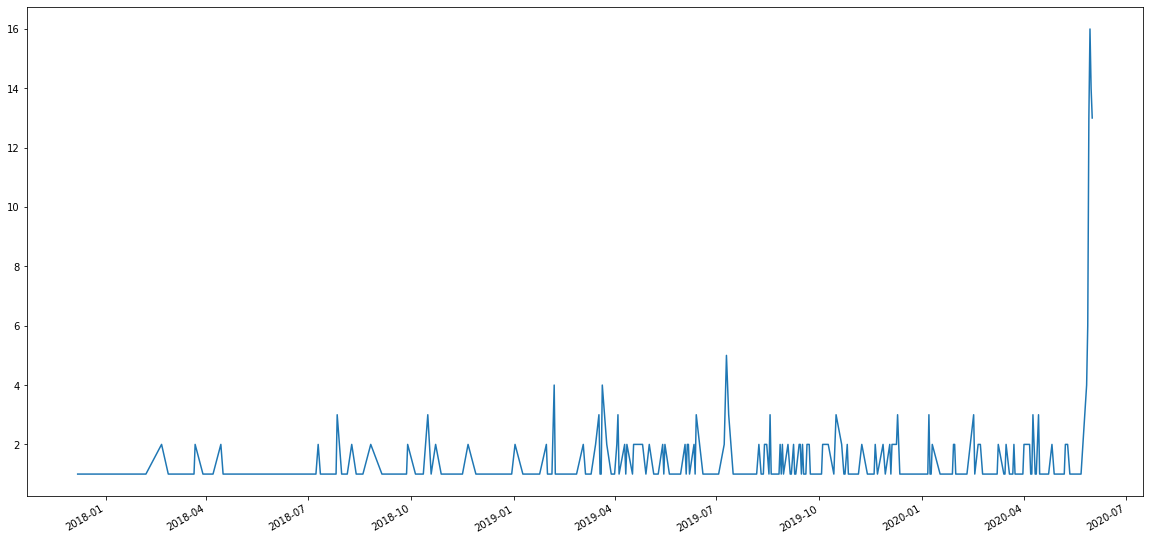

In [13]:
df_limpo['date'].value_counts().plot(figsize=(20,10))

In [14]:
Xtrain, Xval = features[df_limpo['date']<'2019-09-01'], features[df_limpo['date']>='2019-09-01']
ytrain, yval = y[df_limpo['date']<'2019-09-01'],y[df_limpo['date']>='2019-09-01'],
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((237, 2), (236, 2), (237,), (236,))

In [15]:
mdl = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight="balanced")
mdl.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [16]:
yval.mean()

0.1694915254237288

In [17]:
p = mdl.predict_proba(Xval)[:, 1]

In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [19]:
average_precision_score(yval,p)

0.1724137931034483

In [20]:
roc_auc_score(yval,p)

0.5

In [21]:
from sklearn.tree import plot_tree

In [22]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[Text(334.79999999999995, 453.0, 'views <= 366045.0\ngini = 0.5\nsamples = 237\nvalue = [118.5, 118.5]'),
 Text(223.2, 271.8, 'views <= 137235.5\ngini = 0.499\nsamples = 224\nvalue = [109.894, 118.5]'),
 Text(111.6, 90.59999999999997, 'gini = 0.499\nsamples = 202\nvalue = [103.274, 93.983]'),
 Text(334.79999999999995, 90.59999999999997, 'gini = 0.335\nsamples = 22\nvalue = [6.62, 24.517]'),
 Text(446.4, 271.8, 'gini = 0.0\nsamples = 13\nvalue = [8.606, 0.0]')]

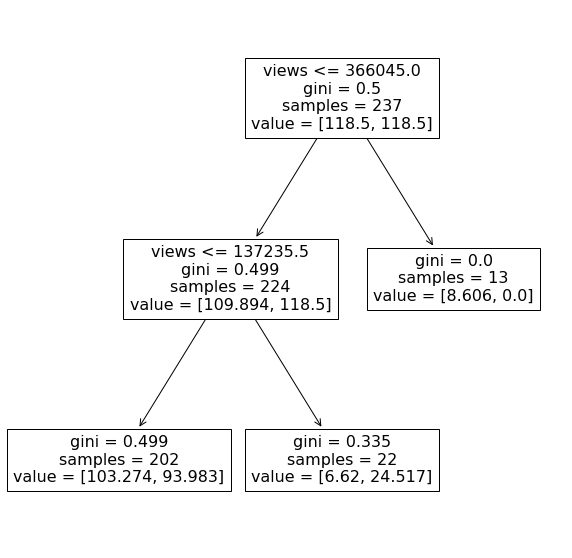

In [23]:
fig, ax = pylab.subplots(1,1, figsize=(10,10))
plot_tree(mdl, ax=ax, feature_names=Xtrain.columns)